# Data / Feature engineering Notebook
This notebook's purpose is to show how one might:

1. Pull some data in. Validate a schema.
2. Process it into features.
3. Save it.

Using feature engineering as the context. The transforms here are not complex, but hopefully illustrative of how one might use Hamilton in this context.

In terms of this notebook, it's structured the following way:

1. we do some setup
2. then cover what Hamilton replaces
3. then dive into pulling data and saving it
4. add DAGWorks (optional) to view executions/versions/nicer UI.
5. then cover feature engineering


# Notebook setup


In [1]:
from IPython.display import clear_output

Uncomment and run the cell below if you are in a Google Colab environment. It will:

1. Mount google drive. You will be asked to authenticate and give permissions.
2. Change directory to google drive.
3. Make a directory "hamilton-tutorials"
4. Change directory to it.
5. Clone this repository to your google drive
6. Move your current directory to the example
7. Install requirements.
8. This means that any modifications will be saved, and you won't lose them if you close your browser.

In [2]:
## 1. Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
## 2. Change directory to google drive.
# %cd /content/drive/MyDrive
## 3. Make a directory "hamilton-tutorials"
# !mkdir hamilton-tutorials
## 4. Change directory to it.
# %cd hamilton-tutorials
## 5. Clone this repository to your google drive
# !git clone https://github.com/DAGWorks-Inc/hamilton-tutorials/
## 6. Move your current directory to the example
# %cd hamilton-tutorials/2023-11-14/titanic_dataset
## 7. Install requirements.
# %pip install -r requirements.txt
# clear_output()  # optionally clear outputs
# To check your current working directory you can type `!pwd` in a cell and run it.

In [1]:
import os
import numpy as np
import pandas as pd
from hamilton import driver, base
from hamilton.function_modifiers import source
from IPython.display import display

# Use autoreload to automatically reload our function modules
%load_ext autoreload
%autoreload 1

# if you want to connect to DAGWorks -- replace these here.
# you can sign up for a free account at www.dagworks.io.
DAGWORKS_API_KEY = os.environ["DAGWORKS_API_KEY"]
DAGWORKS_PROJECT_ID = 81
DAGWORKS_PROJECT_EMAIL = "stefan@dagworks.io"

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


---------

# Reminder - what is Hamilton replacing?
Rather than writing procedural code in scripts that you then have to worry about how to test, maintain, reuse, etc. Hamilton allows you to write functions that are "pure" and then compose them together into a dataflow.

In [2]:
# Old way
def load_data():
    return pd.DataFrame({"spend": [1, 10, 50, 100, 200, 400], "signups": [10, 10, 20, 40, 40, 50]})
data = load_data()
data['avg_3wk_spend'] = data['spend'].rolling(3).mean()
data['spend_per_signup'] = data['spend']/data['signups']
spend_mean = data['spend'].mean()
data['spend_zero_mean'] = data['spend'] - spend_mean
spend_std_dev = data['spend'].std()
data['spend_zero_mean_unit_variance'] = data['spend_zero_mean']/spend_std_dev
print(data.to_string())

   spend  signups  avg_3wk_spend  spend_per_signup  spend_zero_mean  spend_zero_mean_unit_variance
0      1       10            NaN               0.1      -125.833333                      -0.825849
1     10       10            NaN               1.0      -116.833333                      -0.766781
2     50       20      20.333333               2.5       -76.833333                      -0.504260
3    100       40      53.333333               2.5       -26.833333                      -0.176108
4    200       40     116.666667               5.0        73.166667                       0.480195
5    400       50     233.333333               8.0       273.166667                       1.792802


In [6]:
%%writefile hw_funcs.py
import pandas as pd
# New way
def avg_3wk_spend(spend: pd.Series) -> pd.Series:
  """Rolling 3 day average spend."""
  return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
  """The cost per signup in relation to spend."""
  return spend / signups


def spend_mean(spend: pd.Series) -> float:
  """Shows function creating a scalar. In this case it computes the mean of the entire column."""
  return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
  """Shows function that takes a scalar. In this case to zero mean spend."""
  return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
  """Function that computes the standard deviation of the spend column."""
  return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
  """Function showing one way to make spend have zero mean and unit variance."""
  return spend_zero_mean / spend_std_dev

Overwriting hw_funcs.py


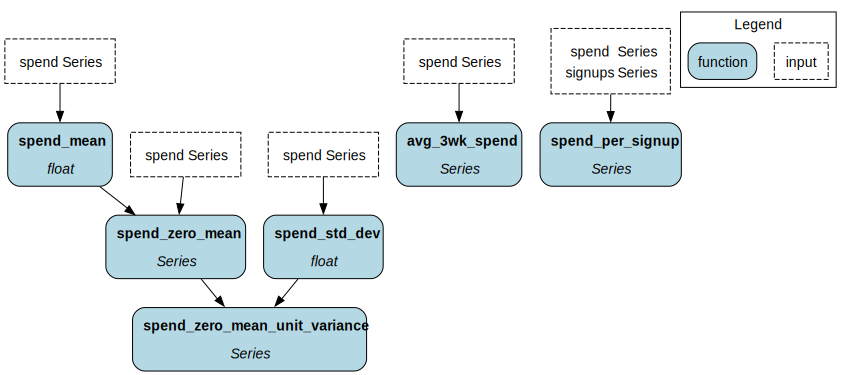

In [63]:
from hamilton import driver
%aimport hw_funcs
config = {}
dr = (
        driver.Builder()
        .with_modules(hw_funcs)
        .with_config(config)
        .with_adapter(base.SimplePythonDataFrameGraphAdapter())  # make output return a dataframe, else it's a dict.
        .build()
    )
dr.display_all_functions(orient="TB")  # shows "provenance", a form of lineage

In [64]:
outputs=["spend", "signups", "avg_3wk_spend", "spend_zero_mean_unit_variance"]

# Here are few things to try and see what happens -- uncomment one and see what happens.
#df = dr.execute(outputs) # -- this will error, saying "spend" not provided.
#df = dr.execute(["foo"]) # -- this will error saying "foo" doesn't exist.
df = dr.execute(outputs, inputs=load_data()) #  -- normal execution.
#df = dr.execute(outputs, inputs=load_data(), overrides={"spend_zero_mean": 10.2})  # can overide/inject data.
#df = dr.materialize(additional_vars=outputs, inputs=load_data()) # return tuple, of meta + dict of outputs.
df

,spend,signups,avg_3wk_spend,spend_zero_mean_unit_variance
0,1,10,NaN,-0.825849
1,10,10,NaN,-0.766781
2,50,20,20.333333,-0.504260
3,100,40,53.333333,-0.176108
4,200,40,116.666667,0.480195
5,400,50,233.333333,1.792802


# Iteration pattern
There are several ways to iterate on Hamilton code. We're looking to make this even simpler, but here's a few ways in a notebook:
1. Write a function in the module. Use auto-reloading, and build out the DAG as you go.
2. Write the function, develop the logic, and then place into the module.
3. Open up a python module, and develop there alongside the notebook.
4. there's probably others..

Note: you can cache results and override DAG execution for quick iteration.

In [67]:
# Example of (2) -- write function
def my_new_func(avg_3wk_spend: pd.Series, signups: pd.Series) -> pd.Series:
    return avg_3wk_spend / signups

# test
print(my_new_func(df["avg_3wk_spend"], df["signups"]))

# move to module...

0         NaN
1         NaN
2    1.016667
3    1.333333
4    2.916667
5    4.666667
dtype: float64


# Testing Hamilton Code
Hamilton code is always unit testable.
Integration testing is also easy, since Hamilton only walks the graph for the dependent functions required.

In [18]:
def test_avg_3wk_spend():
    """I'm writing them as one large block here. But ideally you'd use pytest.mark.parameterized,
    and have some pretty clean unit test code.

    Also ChatGPT does a good job of coming up with tests to simple functions...
    """
    spend_data = pd.Series([10, 20, 30, 40, 50])
    expected_output = pd.Series([None, None, 20.0, 30.0, 40.0])
    pd.testing.assert_series_equal(avg_3wk_spend(spend_data), expected_output, check_names=False)

    # Test with all identical values
    spend_data = pd.Series([5, 5, 5, 5, 5])
    expected_output = pd.Series([None, None, 5.0, 5.0, 5.0])
    pd.testing.assert_series_equal(avg_3wk_spend(spend_data), expected_output, check_names=False)

    # Test with a series containing NaN values
    spend_data = pd.Series([10, None, 30, 40, 50])
    expected_output = pd.Series([None, None, None, None, 40.0])  
    pd.testing.assert_series_equal(avg_3wk_spend(spend_data), expected_output, check_names=False)

    # Test with an empty series
    spend_data = pd.Series([], dtype=float)
    expected_output = pd.Series([], dtype=float)
    pd.testing.assert_series_equal(avg_3wk_spend(spend_data), expected_output, check_names=False)

    # Test with a series shorter than 3
    spend_data = pd.Series([10, 20])
    expected_output = pd.Series([None, None], dtype=float)
    pd.testing.assert_series_equal(avg_3wk_spend(spend_data), expected_output, check_names=False)

test_avg_3wk_spend()

--------------

# Write the code to load data
The following code defines creating a dataframe and validating its schema.

There is no "data joining" here really, but you could go to a SQL database, or many files, etc., and perform the joins you want on data and then pull that into memory for Hamilton to then operate over.

Note: you need to manage indexes/row alignment when processing. With Pandas this manifests itself as setting the right indexes when you load data.

Note: it uses @config.when to switch how data is loaded.

In [30]:
%%writefile data_loader.py
"""
This module contains our data loading functions.
"""
from typing import List

import pandas as pd
import pandera as pa
from sklearn import datasets

from hamilton.function_modifiers import check_output, config, extract_columns, load_from, source


def _sanitize_columns(df_columns: List[str]) -> List[str]:
    """Renames columns to be valid hamilton names -- and lower cases them.
    :param df_columns: the current column names.
    :return: sanitize column names that work with Hamilton
    """
    return [
        c.strip().replace(".", "_").replace("/", "_per_").replace(" ", "_").lower()
        for c in df_columns
    ]


# schema to validate against
passengers_df_schema = pa.DataFrameSchema(
    {
        "pclass": pa.Column(int, nullable=False),
        # "pclass": pa.Column(float, nullable=False),  # swap this for the above to fail/warn
        "sex": pa.Column(str, nullable=False),
        "age": pa.Column(float, nullable=True),
        "parch": pa.Column(int, nullable=False),
        "sibsp": pa.Column(int, nullable=False),
        "fare": pa.Column(float, nullable=True),
        "embarked": pa.Column(str, nullable=True),
        "name": pa.Column(str, nullable=False),
        "ticket": pa.Column(str, nullable=False),
        "boat": pa.Column(str, nullable=True),
        "body": pa.Column(float, nullable=True),
        "home_dest": pa.Column(str, nullable=True),
        "cabin": pa.Column(str, nullable=True),
        "survived": pa.Column(pa.dtypes.Category, nullable=False),
    },
    strict=True,
)


@config.when(loader="openml")
def raw_passengers_df__openml() -> pd.DataFrame:
    """Pulls data from the web. Only becomes a node in the DAG if `openml` is specified.

    :return: dataframe of data.
    """
    base, targets = datasets.fetch_openml("titanic", parser='auto', version=1, as_frame=True, return_X_y=True)
    df = pd.concat([base, targets], axis=1)
    return df


@config.when(loader="parquet")
@load_from.parquet(path=source("titanic_dataset_path"))
def raw_passengers_df__parquet(raw_passengers: pd.DataFrame) -> pd.DataFrame:
    """Pulls data from the web. Only becomes a node in the DAG if `openml` is specified.

    :return: dataframe of data.
    """
    return raw_passengers


@extract_columns("pclass", "sex", "age", "parch", "sibsp", "fare", "embarked", "name", "survived")
@check_output(schema=passengers_df_schema, target_="passengers_df", importance="fail")
def passengers_df(raw_passengers_df: pd.DataFrame) -> pd.DataFrame:
    """Function to take in a raw dataframe, check the output, and then extract columns.

    :param raw_passengers_df: the raw dataset we want to bring in.
    :return:
    """
    raw_passengers_df = raw_passengers_df.dropna(subset=["embarked"])
    raw_passengers_df.columns = _sanitize_columns(raw_passengers_df.columns)
    return raw_passengers_df


def target(survived: pd.Series) -> pd.Series:
    """Just hard coding this mapping that we want survived to be our target.

    :param survived:
    :return:
    """
    target_col = survived.copy()
    target_col.name = "target"
    return target_col


Overwriting data_loader.py


In [31]:
# load the data_loader and setup autoreloading
%aimport data_loader

# Load from openml
Here we have a driver that loads data from openml.

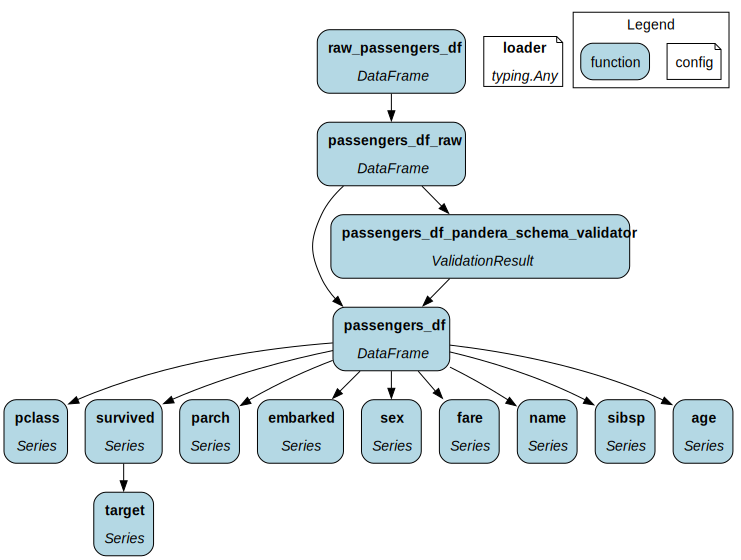

In [32]:
config = {"loader": "openml"}
dr = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .build()
    )
dr.display_all_functions(orient="TB")

# Load from Parquet
Here we have a driver that loads data from parquet. Note it requires an extra input to operate.

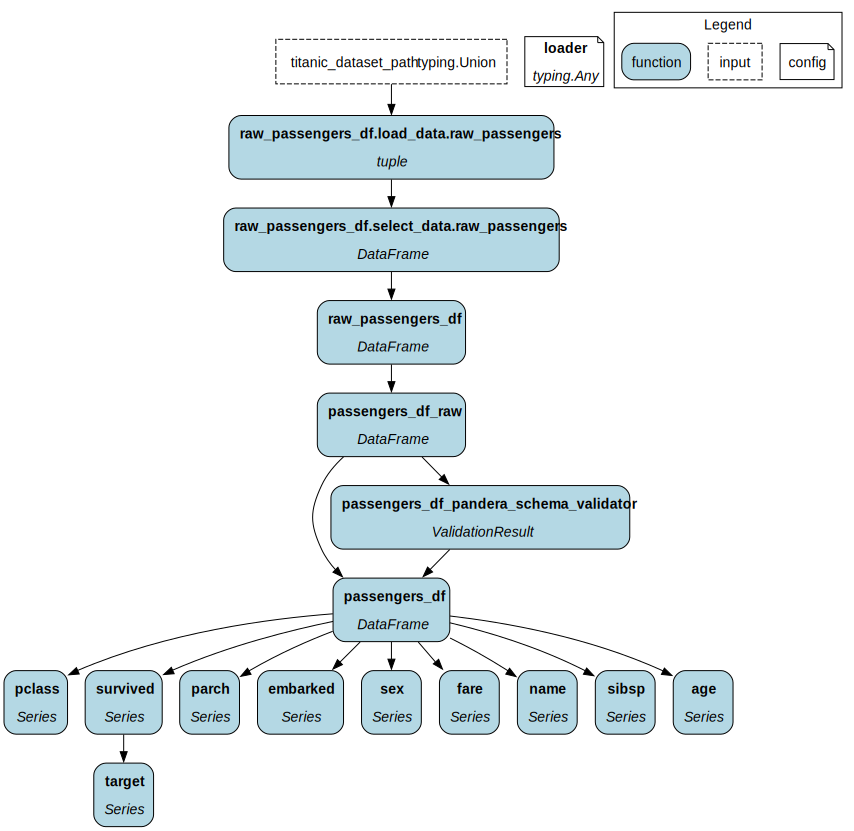

In [33]:
config = {"loader": "parquet"}
dr = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .build()
    )
dr.display_all_functions(orient="TB")

# Load it yourself
When no value is passed that matches @config nodes -- they disappear. In this particular context we can then pass in a dataframe at execution time.

The point here is that without having to change the code, we can swap out different modalities of how data is provided easily. Which is a common cause of technical debt because you couple how data is loaded.

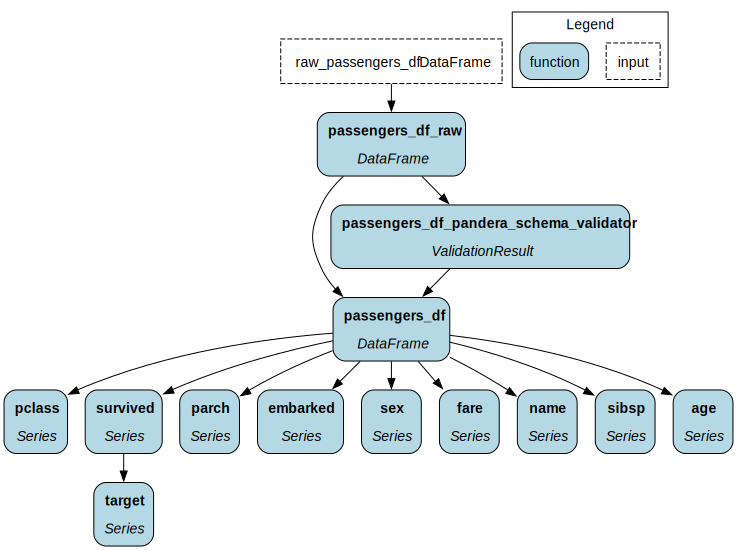

In [34]:
config = {}
dr = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .build()
    )
dr.display_all_functions(orient="TB")

# Let's "load the data"
Let's run the dataflow and talk about saving artifacts.

A few things to note:
1. You can get any intermediate node as output in Hamilton.
2. There are two means to execute a driver. `.execute()` and `.materialize()`.
3. `.execute()` is a way to "fix" what is created/returned when execute is called.
4. `.materialize()` allows more flexiblity to add/adjust what and how is returned, by "injecting" nodes into the dataflow.

Let's see the code. First using `.execute()` and then `.materialize()`.

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/datasets/_arff_parser.py:430: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype)


dict result:
 dict_keys(['pclass', 'sibsp', 'age', 'name', 'parch', 'target'])
0    29.0000
1     0.9167
2     2.0000
3    30.0000
4    25.0000


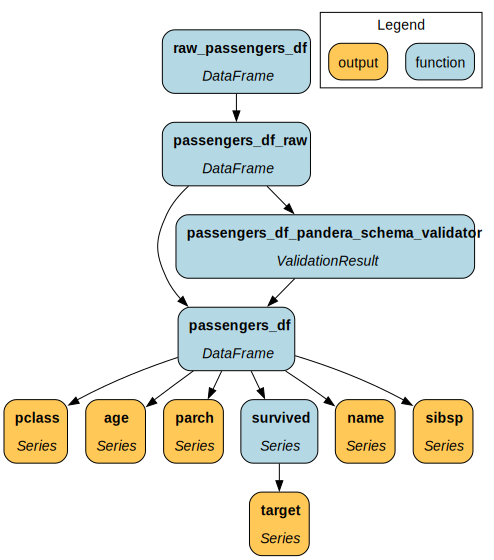

In [37]:

config = {"loader": "openml"}
driver_1 = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .with_adapter(base.DefaultAdapter())
        .build()# .execute() will return a dictionary
    )

# Using .execute()
result_dict = driver_1.execute(outputs)
# we got a dictionary back
print("dict result:\n", result_dict.keys())
print(result_dict["age"].head().to_string())

# note: this is what execution looks like for both
driver_1.visualize_execution(outputs, orient="TB")

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/datasets/_arff_parser.py:430: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype)


df result: 
    pclass  sibsp      age                                             name  parch target
0       1      0  29.0000                    Allen, Miss. Elisabeth Walton      0      1
1       1      1   0.9167                   Allison, Master. Hudson Trevor      2      1
2       1      1   2.0000                     Allison, Miss. Helen Loraine      2      0
3       1      1  30.0000             Allison, Mr. Hudson Joshua Creighton      2      0
4       1      1  25.0000  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)      2      0


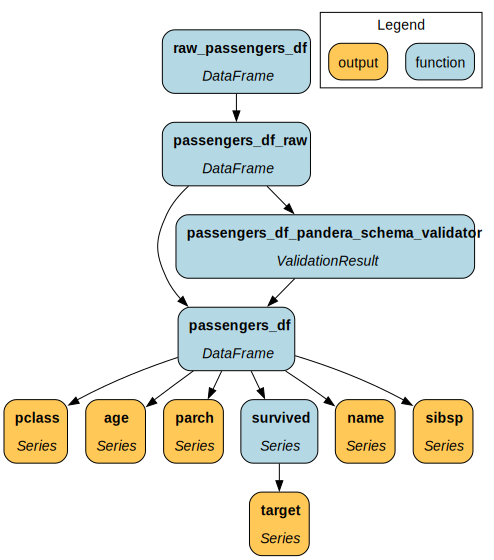

In [38]:
driver_2 = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .with_adapter(base.SimplePythonDataFrameGraphAdapter())
        .build()# .execute() will return dataframe
    )
# can use functions or string names:
outputs = ["pclass", "sibsp", "age", "name", "parch", data_loader.target]

# we got a dataframe back -- uses index to stitch it all together.
result_df = driver_2.execute(outputs)
print("df result: \n", result_df.head().to_string())

# note: this is what execution looks like for both
driver_2.visualize_execution(outputs, orient="TB")

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/datasets/_arff_parser.py:430: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype)


{}
dict_keys(['pclass', 'sibsp', 'age', 'name', 'parch', 'target'])


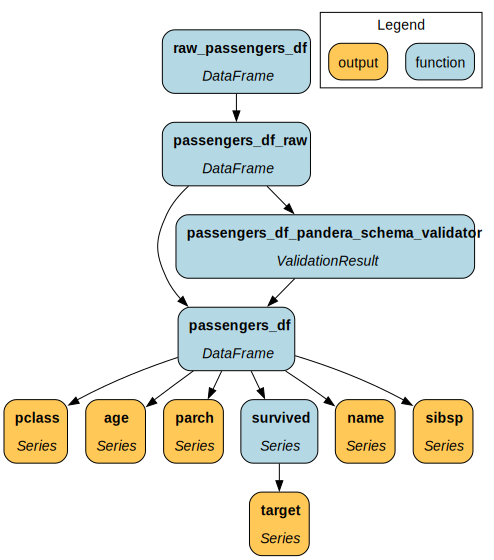

In [39]:
# Using .materialize() -- basic; no materializers

# how to get the same as .execute() with a dictionary adapter:
metadata, dict_outputs = driver_2.materialize(additional_vars=outputs)
print(metadata)
print(dict_outputs.keys())
driver_2.visualize_materialization(additional_vars=outputs, orient="TB")

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/datasets/_arff_parser.py:430: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype)


dict_keys(['output_df'])
dict_keys(['pclass', 'sibsp', 'age', 'name', 'parch', 'target'])


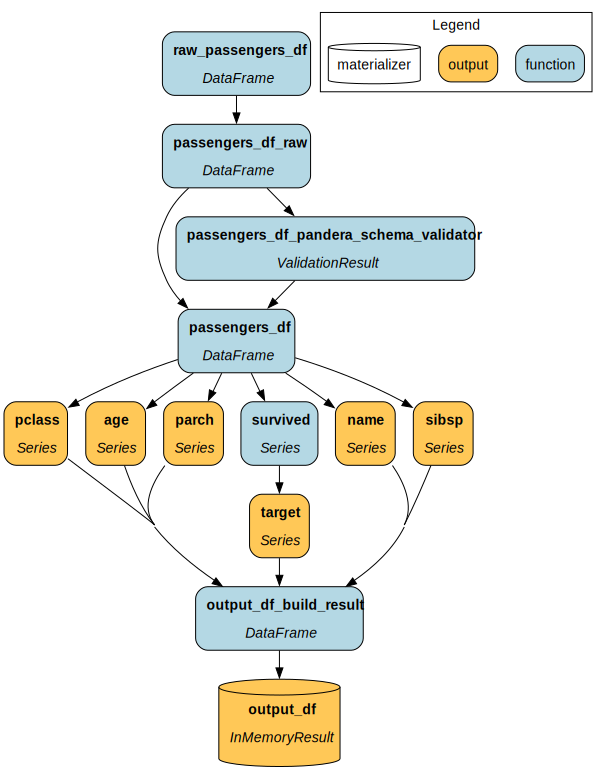

In [40]:
# Using .materialize() -- basic; emulate getting a dataframe in memory & a dictionary...
from hamilton.io.materialization import to

materializers = [
    to.memory(
     id="output_df",
     dependencies=outputs,
     combine=base.PandasDataFrameResult()
    )
]
# get the dictionary & the dataframe back at the same time!
metadata, dict_outputs = driver_2.materialize(
       *materializers, additional_vars=outputs)
print(metadata.keys())
print(dict_outputs.keys())
driver_2.visualize_materialization(*materializers, additional_vars=outputs, orient="TB")

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/datasets/_arff_parser.py:430: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype)


{'output_df':       pclass  sibsp      age                                             name  \
0          1      0  29.0000                    Allen, Miss. Elisabeth Walton   
1          1      1   0.9167                   Allison, Master. Hudson Trevor   
2          1      1   2.0000                     Allison, Miss. Helen Loraine   
3          1      1  30.0000             Allison, Mr. Hudson Joshua Creighton   
4          1      1  25.0000  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
...      ...    ...      ...                                              ...   
1304       3      1  14.5000                             Zabour, Miss. Hileni   
1305       3      1      NaN                            Zabour, Miss. Thamine   
1306       3      0  26.5000                        Zakarian, Mr. Mapriededer   
1307       3      0  27.0000                              Zakarian, Mr. Ortin   
1308       3      0  29.0000                               Zimmerman, Mr. Leo   

      parch t

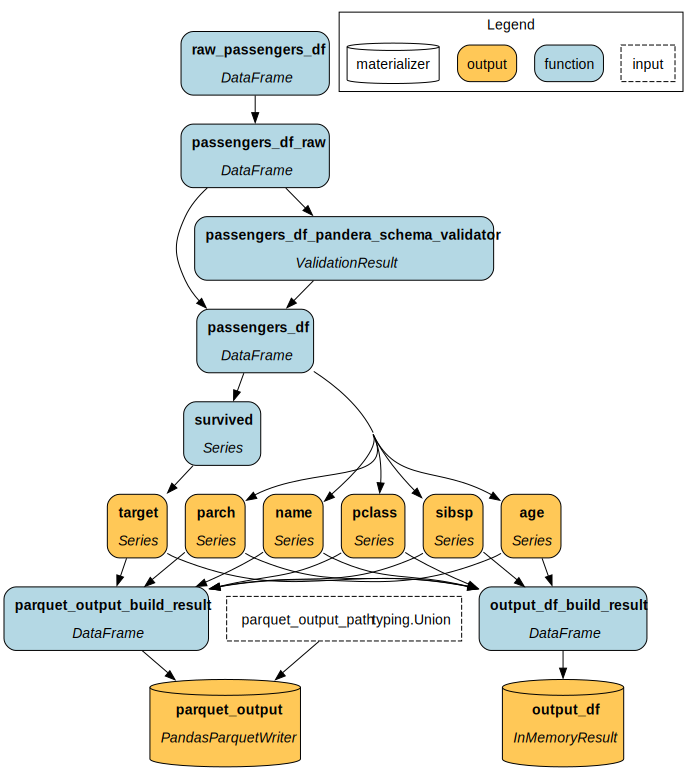

In [41]:
# .materializer but actually save the result -- we can just add to the materializer list!

materializers = [
    to.memory(
     id="output_df",
     dependencies=outputs,
     combine=base.PandasDataFrameResult()
    ),
    to.parquet(
        id="parquet_output",
        path=source("parquet_output_path"),
        dependencies=outputs,
        combine=base.PandasDataFrameResult()
    )
]
# get the dictionary & the dataframe back at the same time!
metadata, dict_outputs = driver_2.materialize(
      *materializers,
    additional_vars=outputs,
    inputs={"parquet_output_path": "temp_feature_output.parquet"})
print(metadata)
print(dict_outputs.keys())
driver_2.visualize_materialization(
    *materializers,
    additional_vars=outputs,
    inputs={"parquet_output_path": "temp_feature_output.parquet"}, orient="TB")

# Add DAGWorks
To get a lot more introspection, etc. We just need to switch out the driver.

In [42]:

from dagworks import driver as dw_driver
dw_dr = dw_driver.Driver(
   config,
   data_loader,
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="titanic-data-loading-v2",
   tags={"env": "local", "where": "notebook"}
)

# .materializer but actually save the result -- we can just add to the materializer list!

materializers = [
    to.memory(
     id="output_df",
     dependencies=outputs,
     combine=base.PandasDataFrameResult()
    ),
    to.parquet(
        id="parquet_output",
        path=source("parquet_output_path"),
        dependencies=outputs,
        combine=base.PandasDataFrameResult()
    )
]
# get the dictionary & the dataframe back at the same time!
metadata, dict_outputs = dw_dr.materialize(
      *materializers,
    additional_vars=outputs,
    inputs={"parquet_output_path": "temp_feature_output.parquet"})
print(metadata)
print(dict_outputs.keys())
# Go see it in the UI -- see the URL in the output.

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/datasets/_arff_parser.py:430: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype)

Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/81/runs/18497



{'output_df':       pclass  sibsp      age                                             name  \
0          1      0  29.0000                    Allen, Miss. Elisabeth Walton   
1          1      1   0.9167                   Allison, Master. Hudson Trevor   
2          1      1   2.0000                     Allison, Miss. Helen Loraine   
3          1      1  30.0000             Allison, Mr. Hudson Joshua Creighton   
4          1      1  25.0000  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
...      ...    ...      ...                                              ...   
1304       3      1  14.5000                             Zabour, Miss. Hileni   
1305       3      1      NaN                            Zabour, Miss. Thamine   
1306       3      0  26.5000                        Zakarian, Mr. Mapriededer   
1307       3      0  27.0000                              Zakarian, Mr. Ortin   
1308       3      0  29.0000                               Zimmerman, Mr. Leo   

      parch t

# Now let's transform the data
How should we think about extending what we've done? Simple. Just add nodes & edges!

Reminder: the contract you need to fulfill is that functions that depend on what was loaded, just need to declare a parameter with the corresponding name & type.

With this in mind, we can create an independent module, that isn't coupled to this initial dataset, other than being coupled via "naming" of the outputs mapping to inputs. So that's what we'll do below.

The task of the code below is to create a dataset for training, after transforming the data.

In [43]:
%%writefile features.py
"""
This is a module that contains our feature transforms.
"""
import pickle
from typing import Set

import pandas as pd

# from sklearn.preprocessing import OneHotEncoder
from sklearn import impute  # import KNNImputer
from sklearn import preprocessing

from hamilton.function_modifiers import check_output, config


def rare_titles() -> Set[str]:
    """Rare titles we've curated"""
    return {
        "Capt",
        "Col",
        "Don",
        "Dona",
        "Dr",
        "Jonkheer",
        "Lady",
        "Major",
        "Mlle",
        "Mme",
        "Ms",
        "Rev",
        "Sir",
        "the Countess",
    }


@check_output(data_type=int)
def family_size(parch: pd.Series, sibsp: pd.Series) -> pd.Series:
    return parch + sibsp


def normalized_name(name: pd.Series) -> pd.Series:
    """I believe this actually gets the honorific, not the name."""
    return name.apply(lambda x: x.split(",")[1].split(".")[0].strip())


def title(normalized_name: pd.Series, rare_titles: Set[str]) -> pd.Series:
    return normalized_name.apply(lambda n: "rare" if n in rare_titles else n)


def is_alone(family_size: pd.Series) -> pd.Series:
    return (family_size == 1).astype(int)


def one_hot_encoder() -> preprocessing.OneHotEncoder:
    return preprocessing.OneHotEncoder(handle_unknown="ignore", sparse=False)


@config.when(model_to_use="create_new")
def fit_categorical_encoder__create_new(
    one_hot_encoder: preprocessing.OneHotEncoder,
    embarked: pd.Series,
    sex: pd.Series,
    pclass: pd.Series,
    title: pd.Series,
    is_alone: pd.Series,
) -> preprocessing.OneHotEncoder:
    cat_df = pd.concat([embarked, sex, pclass, title, is_alone], axis=1)
    cat_df.columns = cat_df.columns.astype(str)
    one_hot_encoder.fit(cat_df)
    return one_hot_encoder


@config.when(model_to_use="use_existing")
def fit_categorical_encoder__use_existing(
    categorical_encoder_path: str,
) -> preprocessing.OneHotEncoder:
    with open(categorical_encoder_path, "rb") as f:
        return pickle.load(f)


def categorical_df(
    fit_categorical_encoder: preprocessing.OneHotEncoder,
    embarked: pd.Series,
    sex: pd.Series,
    pclass: pd.Series,
    title: pd.Series,
    is_alone: pd.Series,
) -> pd.DataFrame:
    """This creates the dataframe of categorical features.

    The number of "features" output depends on the number of categories.

    :param fit_categorical_encoder:
    :param embarked:
    :param sex:
    :param pclass:
    :param title:
    :param is_alone:
    :return:
    """
    cat_df = pd.concat([embarked, sex, pclass, title, is_alone], axis=1)
    cat_df.columns = cat_df.columns.astype(str)
    cat_df = fit_categorical_encoder.transform(cat_df)
    df = pd.DataFrame(cat_df)
    df.index = embarked.index
    df.columns = [f"categorical_{c}" for c in df.columns]
    return df


def knn_imputer(n_neighbors: int = 5) -> impute.KNNImputer:
    return impute.KNNImputer(n_neighbors=n_neighbors)


@config.when(model_to_use="create_new")
def fit_knn_imputer__create_new(
    knn_imputer: impute.KNNImputer,
    age: pd.Series,
    fare: pd.Series,
    family_size: pd.Series,
) -> impute.KNNImputer:
    num_df = pd.concat([age, fare, family_size], axis=1)
    num_df.columns = num_df.columns.astype(str)
    knn_imputer.fit(num_df)
    return knn_imputer


@config.when(model_to_use="use_existing")
def fit_knn_imputer__use_existing(knn_imputer_path: str) -> impute.KNNImputer:
    with open(knn_imputer_path, "rb") as f:
        return pickle.load(f)


def knn_imputed_df(
    fit_knn_imputer: impute.KNNImputer,
    age: pd.Series,
    fare: pd.Series,
    family_size: pd.Series,
) -> pd.DataFrame:
    """This creates the dataframe of KNN imputed numeric features.

    :param fit_knn_imputer:
    :param age:
    :param fare:
    :param family_size:
    :return:
    """
    num_df = pd.concat([age, fare, family_size], axis=1)
    num_df.columns = num_df.columns.astype(str)
    imputed_df = fit_knn_imputer.transform(num_df)
    df = pd.DataFrame(imputed_df)
    df.index = age.index
    df.columns = [f"knn_imputed_{c}" for c in df.columns]
    return df


def robust_scaler() -> preprocessing.RobustScaler:
    return preprocessing.RobustScaler()


@config.when(model_to_use="create_new")
def fit_scaler__create_new(
    robust_scaler: preprocessing.RobustScaler, knn_imputed_df: pd.DataFrame
) -> preprocessing.RobustScaler:
    robust_scaler.fit(knn_imputed_df)
    return robust_scaler


@config.when(model_to_use="use_existing")
def fit_scaler__use_existing(scaler_path: str) -> preprocessing.RobustScaler:
    with open(scaler_path, "rb") as f:
        return pickle.load(f)


def scaled_numeric_df(
    fit_scaler: preprocessing.RobustScaler, knn_imputed_df: pd.DataFrame
) -> pd.DataFrame:
    """This creates the dataframe of scaled numeric features.

    :param fit_scaler:
    :param knn_imputed_df:
    :return:
    """
    num_df = fit_scaler.transform(knn_imputed_df)
    df = pd.DataFrame(num_df)
    df.index = knn_imputed_df.index
    df.columns = [f"scaled_numeric_{c}" for c in df.columns]
    return df


def data_set(
    scaled_numeric_df: pd.DataFrame, categorical_df: pd.DataFrame, target: pd.Series
) -> pd.DataFrame:
    """This function creates our dataset.

    Following what was in the code, this is how the features are stuck together.

    :param scaled_numeric_df:
    :param categorical_df:
    :param target:
    :return:
    """
    return pd.concat([scaled_numeric_df, categorical_df, target], axis=1)


def inference_set(scaled_numeric_df: pd.DataFrame, categorical_df: pd.DataFrame) -> pd.DataFrame:
    """This function creates an inference set.

    :param scaled_numeric_df:
    :param categorical_df:
    :return:
    """
    return pd.concat([scaled_numeric_df, categorical_df], axis=1)


Overwriting features.py


In [44]:
# import for reloading features.py
%aimport features

# Let's independently see the features module!
We can independently run this module very easily.

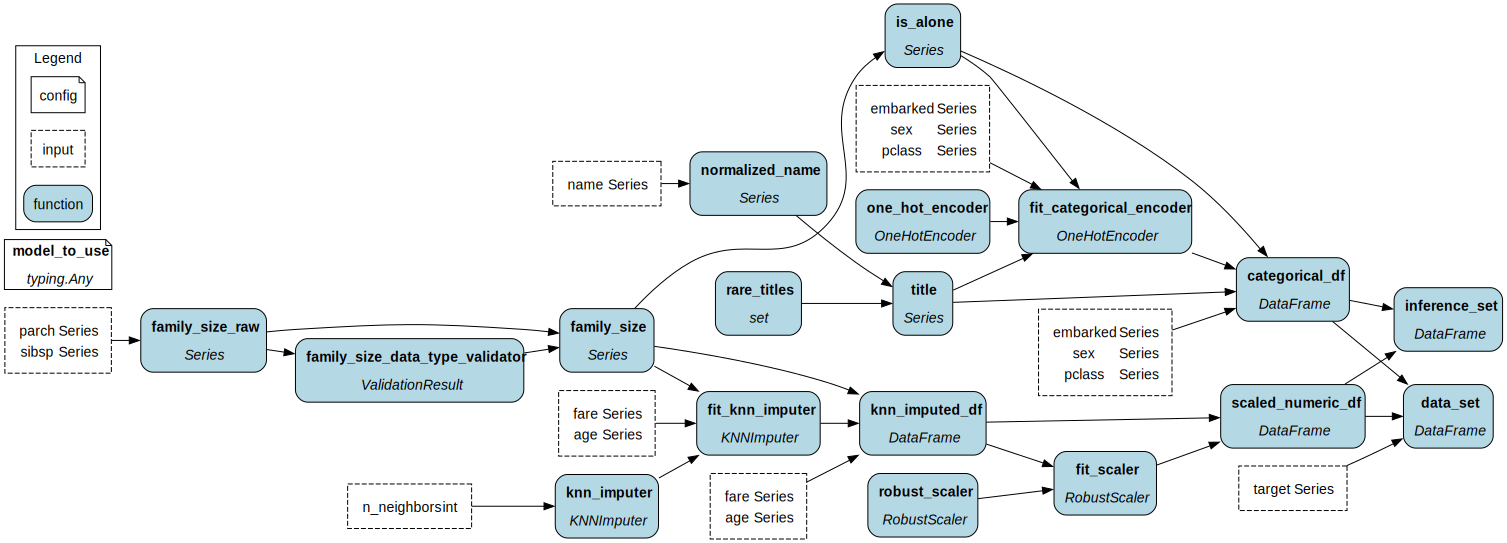

In [46]:
config = {"model_to_use": "create_new"}
dr = (
        driver.Builder()
        .with_modules(features)
        .with_config(config)
        .build()
    )
dr.display_all_functions(orient="LR")

# Let's connect data loading with features
Just to show composability -- we can now create a larger dataflow, by including more modules!

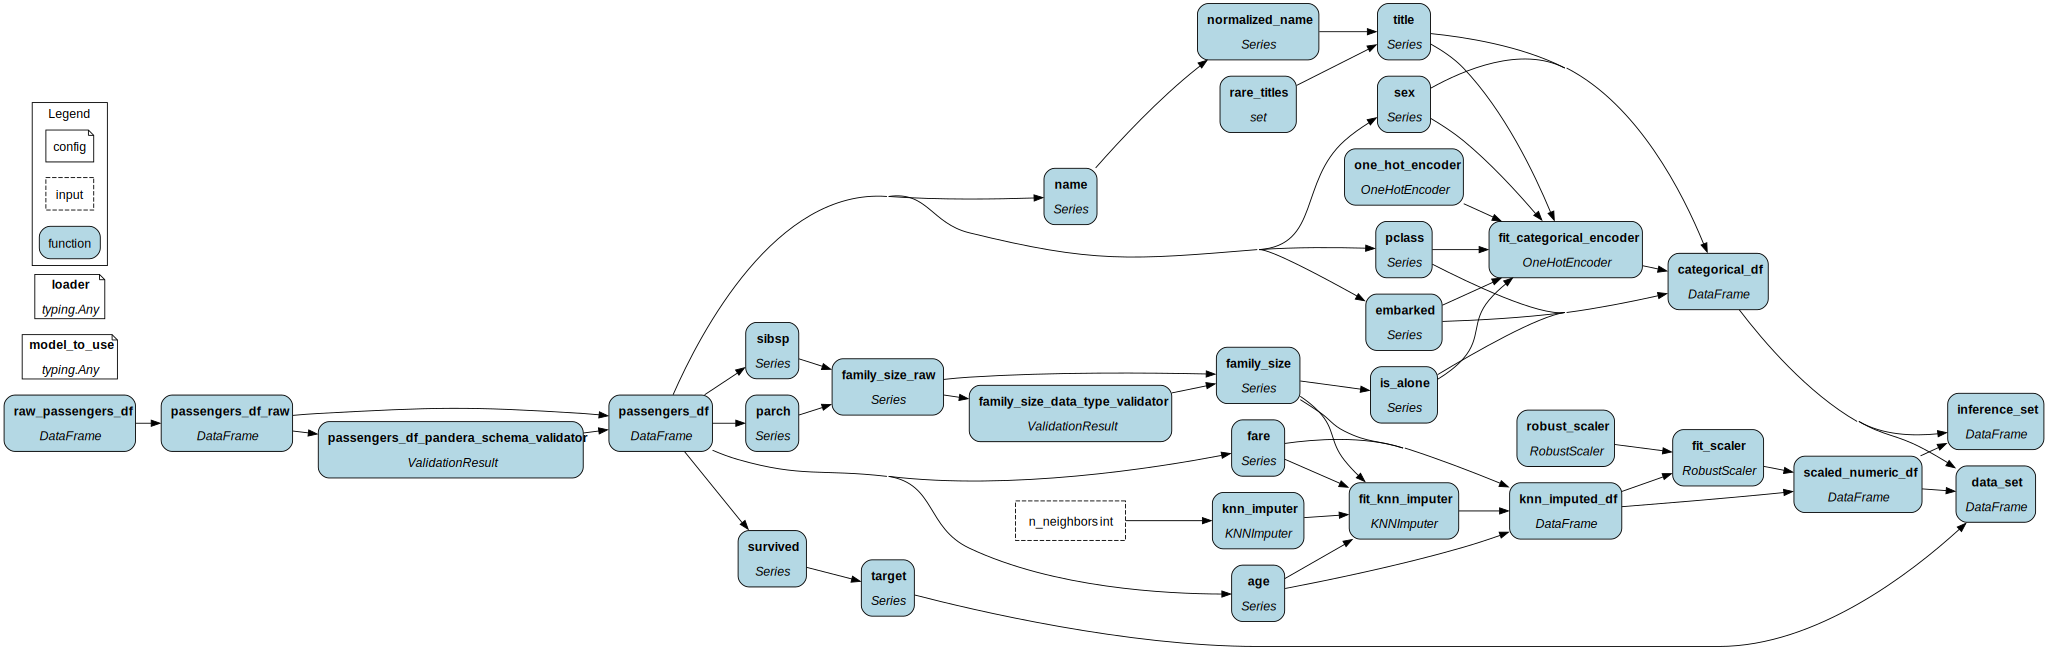

In [47]:
config = {"model_to_use": "create_new", "loader":"openml"}
dr = (
        driver.Builder()
        .with_modules(data_loader, features)
        .with_config(config)
        .build()
    )
dr.display_all_functions(orient="LR")

# Let's actually run it

In [48]:
outputs = [features.inference_set, features.data_set]
materializers = [
    # to.memory(
    #  id="feature_df",
    #  dependencies=outputs,
    #  combine=base.PandasDataFrameResult()
    # ),
    to.parquet(
        id="data_set_parquet",
        path=source("data_set_parquet_output_path"),
        dependencies=[features.data_set],
        combine=base.PandasDataFrameResult()
    ),
    to.parquet(
        id="inference_set_parquet",
        path=source("inference_set_parquet_output_path"),
        dependencies=[features.inference_set],
        combine=base.PandasDataFrameResult()
    )
]
# just get the data sets without materializing anything.
metadata, dict_outputs = dr.materialize(
      *materializers,
    additional_vars=outputs, 
    inputs={"data_set_parquet_output_path": "data_set.parquet", "inference_set_parquet_output_path": "inference_set.parquet"}
)
print(metadata)
print(dict_outputs.keys())
print(dict_outputs["inference_set"].head().to_string())
print(dict_outputs["data_set"].head().to_string())

{'data_set_parquet': {'size': 31109, 'path': 'data_set.parquet', 'last_modified': 1699923376.3757923, 'timestamp': 1699952176.375931}, 'inference_set_parquet': {'size': 30226, 'path': 'inference_set.parquet', 'last_modified': 1699923376.3792048, 'timestamp': 1699952176.379327}}
dict_keys(['inference_set', 'data_set'])
   scaled_numeric_0  scaled_numeric_1  scaled_numeric_2  categorical_0  categorical_1  categorical_2  categorical_3  categorical_4  categorical_5  categorical_6  categorical_7  categorical_8  categorical_9  categorical_10  categorical_11  categorical_12  categorical_13  categorical_14
0          0.000000          8.421302               0.0            0.0            0.0            1.0            1.0            0.0            1.0            0.0            0.0            0.0            1.0             0.0             0.0             0.0             1.0             0.0
1         -1.702018          5.864007               3.0            0.0            0.0            1.0        

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/datasets/_arff_parser.py:430: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype)
/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packa

# Add the connection to  DAGWorks

In [50]:
from dagworks import driver as dw_driver
from hamilton import driver 
dw_dr = dw_driver.Driver(
   config,
   data_loader, features,
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="titanic-data-loading-features-v2",
   tags={"env": "local", "where": "notebook"}
)
materializers = [
    to.memory(
     id="training_set_df",
     dependencies=[features.data_set],
     combine=base.PandasDataFrameResult()
    ),
    to.memory(
     id="test_set_df",
     dependencies=[features.inference_set],
     combine=base.PandasDataFrameResult()
    ),
    to.parquet(
        id="data_set_parquet",
        path=source("data_set_parquet_output_path"),
        dependencies=[features.data_set],
        combine=base.PandasDataFrameResult()
    ),
    to.parquet(
        id="inference_set_parquet",
        path=source("inference_set_parquet_output_path"),
        dependencies=[features.inference_set],
        combine=base.PandasDataFrameResult()
    )
]
metadata, dict_outputs = dw_dr.materialize(
    *materializers, 
    additional_vars=outputs, 
    inputs={"data_set_parquet_output_path": "data_set.parquet", "inference_set_parquet_output_path": "inference_set.parquet"}
)
print(metadata)
print(dict_outputs.keys())
print(dict_outputs["inference_set"].head().to_string())
print(dict_outputs["data_set"].head().to_string())
# dw_dr.execute(outputs)


/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/datasets/_arff_parser.py:430: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype)
/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packa

{'training_set_df':       scaled_numeric_0  scaled_numeric_1  scaled_numeric_2  categorical_0  \
0             0.000000          8.421302               0.0            0.0   
1            -1.702018          5.864007               3.0            0.0   
2            -1.636364          5.864007               3.0            0.0   
3             0.060606          5.864007               3.0            0.0   
4            -0.242424          5.864007               3.0            0.0   
...                ...               ...               ...            ...   
1304         -0.878788          0.000000               1.0            1.0   
1305         -0.503030          0.000000               1.0            1.0   
1306         -0.151515         -0.309215               0.0            1.0   
1307         -0.121212         -0.309215               0.0            1.0   
1308          0.000000         -0.281413               0.0            0.0   

      categorical_1  categorical_2  categorical_3  cate

# Reusing features for multiple contexts
Read [this blog post](https://blog.dagworks.io/p/feature-engineering-with-hamilton) for more context, but one
of the nice things about Hamilton is that you can reuse your code for multiple context easily.

E.g. you want to run code online in a web-service, so you want the same feature transforms to prevent any training-serving skew coming
from the code itself. So you can't reuse the data loading portion, but you can reuse the feature transform logic!

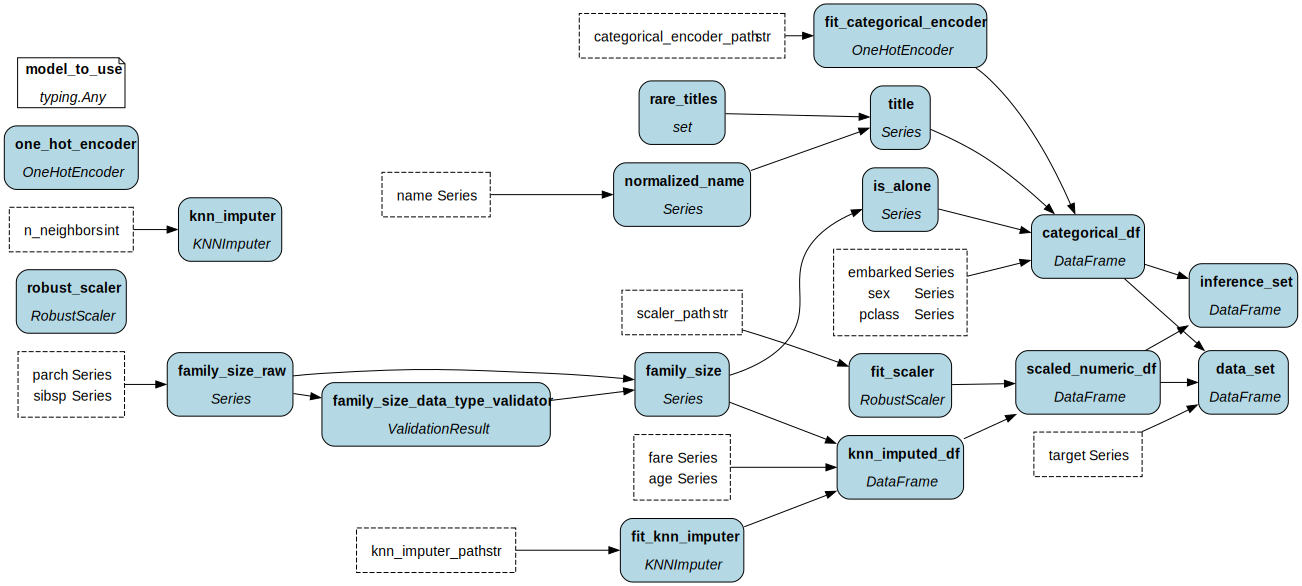

In [61]:
config = {"model_to_use": "use_existing"}
dr = (
        driver.Builder()
        .with_modules(features)
        .with_config(config)
        .build()
    )

dr.display_all_functions(orient="LR", show_legend=False)
# dr.execute(["inference_set"])  # will error and say what's required

In [56]:
# what we need to provide:
vars = dr.list_available_variables()
[(var.name, var.type) for var in vars if var.is_external_input]

[('embarked', pandas.core.series.Series),
 ('sex', pandas.core.series.Series),
 ('pclass', pandas.core.series.Series),
 ('target', pandas.core.series.Series),
 ('parch', pandas.core.series.Series),
 ('sibsp', pandas.core.series.Series),
 ('categorical_encoder_path', str),
 ('knn_imputer_path', str),
 ('scaler_path', str),
 ('age', pandas.core.series.Series),
 ('fare', pandas.core.series.Series),
 ('n_neighbors', int),
 ('name', pandas.core.series.Series),
 ('model_to_use', typing.Any)]

So in our webservice, we just either:

(a) need to provide the required inputs via the request.

(b) or write a module that goes to to feature store to get them for Hamilton to execute.

(c) some mixture of (a) & (b).

# Ad hoc Utils
If you really can't use modules, then you can create one ad-hoc!

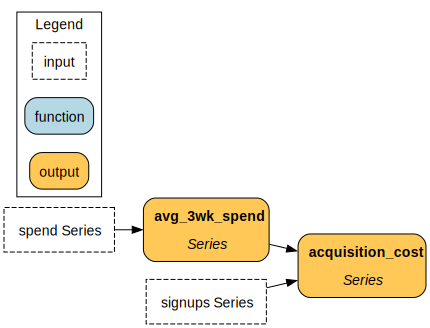

In [51]:
from hamilton import ad_hoc_utils

def avg_3wk_spend(spend: pd.Series) -> pd.Series:
    """Rolling 3 week average spend."""
    return spend.rolling(3).mean()

def acquisition_cost(avg_3wk_spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to a rolling average of spend."""
    return avg_3wk_spend / signups

# Instantiate a common spine for your pipeline
index = pd.date_range("2022-01-01", periods=6, freq="w")
initial_columns = {  # load from actuals or wherever -- this is our initial data we use as input.
    # Note: these do not have to be all series, they could be scalar inputs.
    'signups': pd.Series([1, 10, 50, 100, 200, 400], index=index),
    'spend': pd.Series([10, 10, 20, 40, 40, 50], index=index),
}
# we need to tell hamilton where to load function definitions from
config = {} # we don't have any configuration or invariant data for this example.

temp_module = ad_hoc_utils.create_temporary_module(
     avg_3wk_spend, acquisition_cost)
dr_ = driver.Driver(config, temp_module)  # can pass in multiple modules
# we need to specify what we want in the final dataframe.
output_columns = [
    'spend',
    'signups',
    'avg_3wk_spend',
    'acquisition_cost',
]
# let's create the dataframe!
df = dr_.execute(output_columns, inputs=initial_columns)
# `pip install sf-hamilton[visualization]` earlier you can also do
dr_.visualize_execution(
    final_vars=output_columns,
    inputs=initial_columns
    )

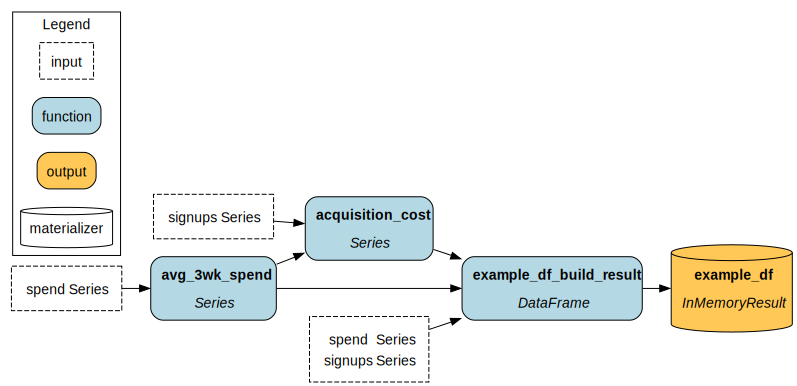

In [52]:
from hamilton import base
dr_.visualize_materialization(
  to.memory(
    id="example_df",
    dependencies=output_columns,
    combine=base.PandasDataFrameResult()
  ),
      inputs=initial_columns
)